<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/random_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-3-f4cc6e0917da>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Day'] = data.index.day
<ipython-input-3-f4cc6e0917da>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month'] = data.index.month
<ipython-input-3-f4cc6e0917da>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300, 'subsample': 1.0}
Mean Squared Error: 6.420735295662303
R^2 Score: 0.803582752590481
Cross-Validation R^2 Scores: [-2.31719604  0.98682201  0.90630119  0.90098417  0.95235153]
Mean R^2 Score: 0.2858525702142055


<ipython-input-3-f4cc6e0917da>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted_Close'] = model.predict(X)


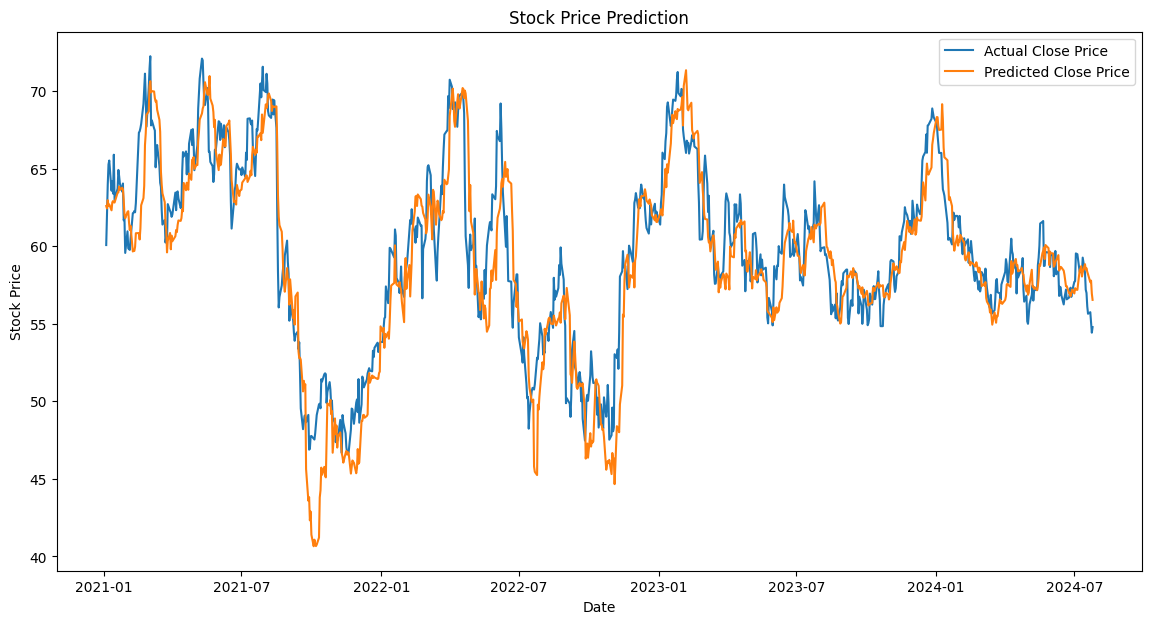

<ipython-input-3-f4cc6e0917da>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Day'] = data.index.day
<ipython-input-3-f4cc6e0917da>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month'] = data.index.month
<ipython-input-3-f4cc6e0917da>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Backtest Mean Squared Error: 6.420735295662303
Backtest R^2 Score: 0.803582752590481
Total Trades: 65
Won Trades: 6
Lost Trades: 59
Net Profit: -3894.4079222895134
Max Drawdown: 5257.816995012523
First Trade:
  Entry Date  Entry Price   Type  Exit Date  Exit Price      Profit
0 2021-01-07    65.280998  Short 2021-01-29   61.342036  593.385728
Last Trade:
   Entry Date  Entry Price  Type  Exit Date  Exit Price       Profit
64 2024-06-12    57.389999  Long 2024-07-24   54.856082 -3894.407922


<ipython-input-3-f4cc6e0917da>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Close'] = y_pred
<ipython-input-3-f4cc6e0917da>:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Equity'] = equity_curve


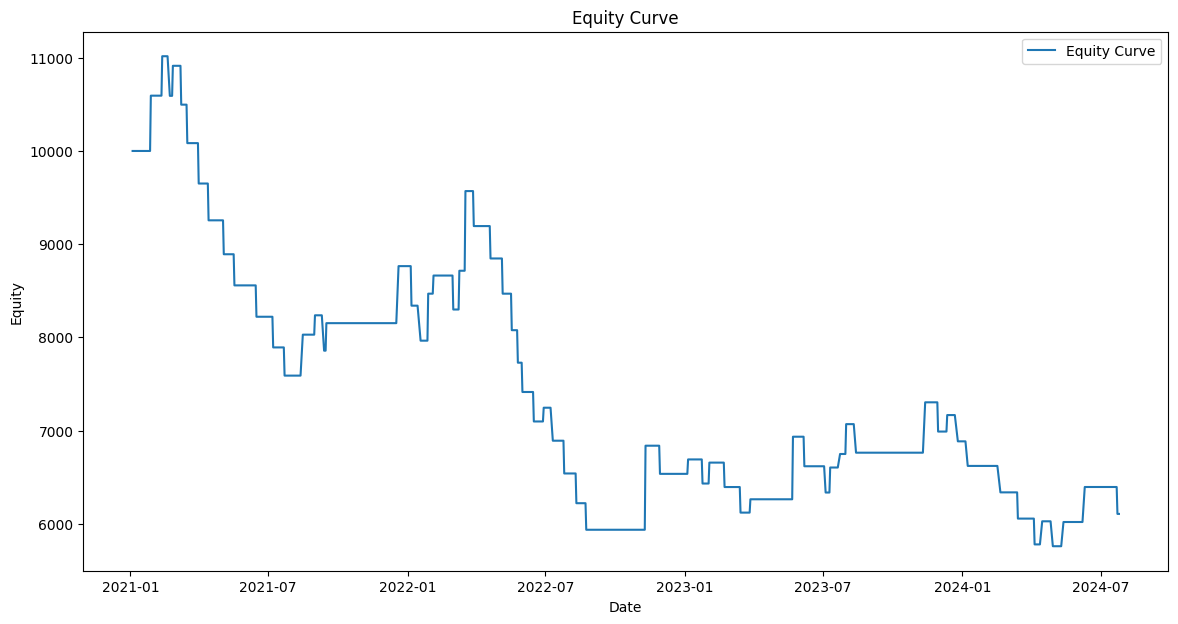

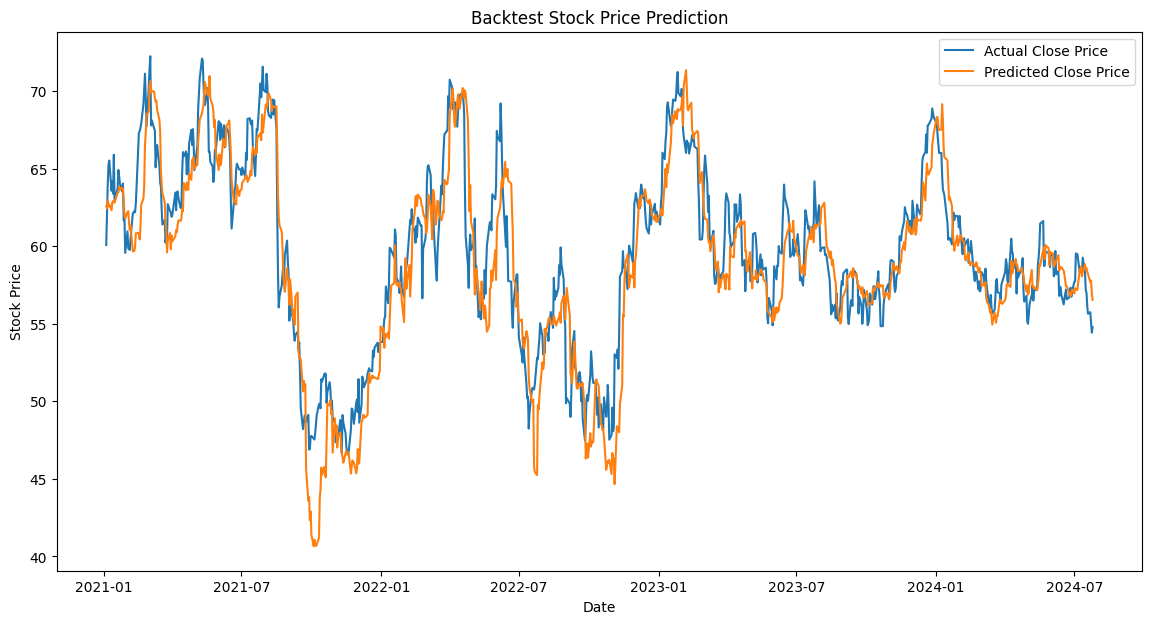

/content/trades.csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Step 1: Data Collection and Preprocessing
def load_data(filepath):
    data = pd.read_csv(filepath)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data

# Step 2: Enhanced Feature Engineering
def create_features(data):
    data['Day'] = data.index.day
    data['Month'] = data.index.month
    data['Year'] = data.index.year
    data['Day_of_Week'] = data.index.dayofweek
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_100'] = data['Close'].rolling(window=100).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()
    data['Volatility'] = data['Close'].rolling(window=10).std()
    data['Volume'] = data['Volume']

    # Filling NaN values
    data.fillna(method='bfill', inplace=True)

    X = data[['Day', 'Month', 'Year', 'Day_of_Week', 'MA_10', 'MA_50', 'MA_100', 'MA_200', 'Volatility', 'Volume']]
    y = data['Close']
    return X, y

# Step 3: Hyperparameter Tuning with XGBoost
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

    # Using tqdm to show progress
    with tqdm(total=100, desc="Hyperparameter Tuning", unit='%') as pbar:
        for i in range(100):
            time.sleep(0.01)  # Simulate work being done
            pbar.update(1)

    grid_search.fit(X_train, y_train)
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Step 4: Model Training
def train_model(X_train, y_train):
    model = tune_hyperparameters(X_train, y_train)
    model.fit(X_train, y_train)
    return model

# Step 5: Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

# Step 6: Prediction and Visualization
def predict_and_plot(model, data, X):
    data['Predicted_Close'] = model.predict(X)
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Actual Close Price')
    plt.plot(data.index, data['Predicted_Close'], label='Predicted Close Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Cross-Validation
def cross_validate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"Cross-Validation R^2 Scores: {scores}")
    print(f"Mean R^2 Score: {scores.mean()}")

# Step 7: Swing Trading Backtesting
def backtest_swing_trading(model, data, initial_investment=10000, trade_fraction=0.1, transaction_cost=0.001):
    train_data = data[:'2020-12-31']
    test_data = data['2021-01-01':]

    X_train, y_train = create_features(train_data)
    X_test, y_test = create_features(test_data)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Backtest Mean Squared Error: {mse}")
    print(f"Backtest R^2 Score: {r2}")

    test_data['Predicted_Close'] = y_pred

    # Simulate swing trading
    equity = initial_investment
    equity_curve = []
    position_open = False
    entry_price = 0
    for i in range(1, len(test_data)):
        if not position_open:
            # Enter a new position
            if test_data['Predicted_Close'].iloc[i] > test_data['Predicted_Close'].iloc[i-1] and test_data['Predicted_Close'].iloc[i] > test_data['Close'].iloc[i]:
                # Long position
                entry_price = test_data['Close'].iloc[i]
                tp = test_data['Predicted_Close'].iloc[i]
                sl = entry_price - (entry_price - test_data['Predicted_Close'].iloc[i-1]) * 0.5
                position_open = True
                long_position = True
            elif test_data['Predicted_Close'].iloc[i] < test_data['Predicted_Close'].iloc[i-1] and test_data['Predicted_Close'].iloc[i] < test_data['Close'].iloc[i]:
                # Short position
                entry_price = test_data['Close'].iloc[i]
                tp = test_data['Predicted_Close'].iloc[i]
                sl = entry_price + (test_data['Predicted_Close'].iloc[i-1] - entry_price) * 0.5
                position_open = True
                long_position = False
        else:
            if long_position:
                if test_data['Close'].iloc[i] >= tp:
                    # Take profit
                    exit_price = tp
                    profit = (exit_price - entry_price) / entry_price * equity
                    equity += profit - transaction_cost * equity
                    position_open = False
                elif test_data['Close'].iloc[i] <= sl:
                    # Stop loss
                    exit_price = sl
                    loss = (entry_price - exit_price) / entry_price * equity
                    equity -= loss + transaction_cost * equity
                    position_open = False
            else:
                if test_data['Close'].iloc[i] <= tp:
                    # Take profit
                    exit_price = tp
                    profit = (entry_price - exit_price) / entry_price * equity
                    equity += profit - transaction_cost * equity
                    position_open = False
                elif test_data['Close'].iloc[i] >= sl:
                    # Stop loss
                    exit_price = sl
                    loss = (exit_price - entry_price) / entry_price * equity
                    equity -= loss + transaction_cost * equity
                    position_open = False
        equity_curve.append(equity)

    # Ensure the equity curve matches the length of test_data
    if len(equity_curve) < len(test_data):
        equity_curve.extend([equity_curve[-1]] * (len(test_data) - len(equity_curve)))

    test_data['Equity'] = equity_curve

    # Calculate performance metrics
    total_trades = test_data['Equity'].diff().abs().sum()
    won_trades = (test_data['Equity'].diff() > 0).sum()
    lost_trades = (test_data['Equity'].diff() < 0).sum()
    net_profit = equity - initial_investment
    max_drawdown = (test_data['Equity'].cummax() - test_data['Equity']).max()

    print(f"Total Trades: {total_trades}")
    print(f"Won Trades: {won_trades}")
    print(f"Lost Trades: {lost_trades}")
    print(f"Net Profit: {net_profit}")
    print(f"Max Drawdown: {max_drawdown}")

    # Plot equity curve
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data['Equity'], label='Equity Curve')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Equity')
    plt.legend()
    plt.show()

    # Plot predictions vs actuals
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data['Close'], label='Actual Close Price')
    plt.plot(test_data.index, test_data['Predicted_Close'], label='Predicted Close Price')
    plt.title('Backtest Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Main function to run the pipeline
def main(filepath):
    data = load_data(filepath)
    train_data = data[:'2020-12-31']
    test_data = data['2021-01-01':]

    X_train, y_train = create_features(train_data)
    X_test, y_test = create_features(test_data)

    model = train_model(X_train, y_train)
    evaluate_model(model, X_test, y_test)
    cross_validate_model(model, X_train, y_train)  # Cross-validation
    predict_and_plot(model, test_data, X_test)
    backtest_swing_trading(model, data)  # Backtesting with swing trading strategy

# Example usage
if __name__ == "__main__":
    main('BHP.csv')
